## 分析目標
+ 資料內容：
    + 資料來源：PTT movie/gossip
    + 資料類別: 漫威/DC  

* 分析主題：分別爬取漫威和DC的電影的文章, 並訓練能夠預測文章是漫威或DC的分類器

## 大綱

1. 套件與資料載入
2. 資料清理
3. 模型訓練
4. 比較模型準度
5. 主題模型分析
    - LDA
    - GuidedLDA
    - 視覺化

In [139]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [140]:
marvel_one = pd.read_csv("raw_data/2008_marvel.csv")  # 匯資料
marvel_one['category'] = 'MV'

In [141]:
marvel_one = marvel_one.drop('system_id', axis=1)

In [142]:
marvel_two = pd.read_csv("raw_data/2017_marvel.csv")  # 匯資料
marvel_two['category'] = 'MV'

In [143]:
marvel_two = marvel_two.drop('system_id', axis=1)

In [144]:
#merge and reset index
df = pd.concat([marvel_one, marvel_two], ignore_index=True)

In [145]:
dc = pd.read_csv("raw_data/dc.csv")  # 匯資料
dc['category'] = 'DC'

dc = dc.drop('system_id', axis=1)



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,

In [146]:
dc_two = pd.read_csv("raw_data/dc_2008.csv")
dc_two['category'] = 'DC'

dc_two = dc_two.drop('system_id', axis=1)


In [147]:
df = pd.concat([df, dc, dc_two], ignore_index=True)

### 2. 資料清理

In [148]:
#change artContent artTitle to string
df['artContent'] = df['artContent'].astype(str)
df['artTitle'] = df['artTitle'].astype(str)

In [149]:
# 移除網址格式
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df.head(3)

,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,...,Unnamed: 4888,Unnamed: 4889,Unnamed: 4890,Unnamed: 4891,Unnamed: 4892,Unnamed: 4893,Unnamed: 4894,Unnamed: 4895,Unnamed: 4896,Unnamed: 4897
0,https://www.ptt.cc/bbs/movie/M.1203700706.A.0B...,影評輕輕鬆鬆無責任瞬間移動移動世界,2008-02-22 17:12:23,totoroJack,movie,原文與劇照請參照請任意轉載但請記得告知原作者謝謝我喜愛好萊塢電影甚至是看了世界上更多非好萊塢...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""yuhung"", ""cm...",None,2018-04-27 17:01:04,ptt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.ptt.cc/bbs/movie/M.1209570769.A.74...,好雷鋼鐵人,2008-04-30 15:46:48,Falcone,movie,首次製作的作品可說繳出一張優秀的成績單先講不滿的地方就是前半的精彩反而令理論上的後段高潮戲顯...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""a558815"", ""c...",None,2018-04-27 17:01:33,ptt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.ptt.cc/bbs/movie/M.1209836216.A.8D...,請益鋼鐵人和移動世界有關係嗎片尾,2008-05-03 17:30:53,masayo,movie,我也來補充一下好了以下是寫給對美漫完全沒有概念的人看的而且主題重點放在電影方面這次台灣翻譯把...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""c5170439"", ""...",None,2018-04-27 17:01:33,ptt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
# 留下 content
df["content"] = df["artTitle"] + df["artContent"]
df = df[["content", "artUrl", "category", "artDate"]]  # 文章內容 文章連結
df.head()

,content,artUrl,category,artDate
0,影評輕輕鬆鬆無責任瞬間移動移動世界原文與劇照請參照請任意轉載但請記得告知原作者謝謝我喜愛好萊...,https://www.ptt.cc/bbs/movie/M.1203700706.A.0B...,MV,2008-02-22 17:12:23
1,好雷鋼鐵人首次製作的作品可說繳出一張優秀的成績單先講不滿的地方就是前半的精彩反而令理論上的後...,https://www.ptt.cc/bbs/movie/M.1209570769.A.74...,MV,2008-04-30 15:46:48
2,請益鋼鐵人和移動世界有關係嗎片尾我也來補充一下好了以下是寫給對美漫完全沒有概念的人看的而且主...,https://www.ptt.cc/bbs/movie/M.1209836216.A.8D...,MV,2008-05-03 17:30:53
3,好雷鋼鐵人時光之硯鋼鐵人時光之硯部落格個人板陽光耀眼劇照版在此鋼鐵人切入了沒人佔領的幽默這一...,https://www.ptt.cc/bbs/movie/M.1210080500.A.5D...,MV,2008-05-06 13:22:10
4,鋼鐵人小勞勃道尼的浮沉人生圖文版小勞勃道尼的浮沉人生鋼鐵人與小勞勃道尼我在人生的不同階段不時...,https://www.ptt.cc/bbs/movie/M.1210388646.A.DC...,MV,2008-05-10 02:58:03


In [151]:
# 看看有幾篇文章
print(f"total docs: {df.shape[0]}")

total docs: 21841


### 斷詞

In [154]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [155]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [156]:
df["words"] = df["content"].apply(getToken).map(" ".join)
df.head()

Building prefix dict from /home/nychian/HW_3/dict/dict.txt ...
2023-05-07 17:35:13,534 : DEBUG : Building prefix dict from /home/nychian/HW_3/dict/dict.txt ...
Loading model from cache /tmp/jieba.u20247a3849bc6c9fcbba07ee911f2fa2.cache
2023-05-07 17:35:13,537 : DEBUG : Loading model from cache /tmp/jieba.u20247a3849bc6c9fcbba07ee911f2fa2.cache
Loading model cost 0.656 seconds.
2023-05-07 17:35:14,192 : DEBUG : Loading model cost 0.656 seconds.
Prefix dict has been built successfully.
2023-05-07 17:35:14,194 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,category,artDate,words
0,影評輕輕鬆鬆無責任瞬間移動移動世界原文與劇照請參照請任意轉載但請記得告知原作者謝謝我喜愛好萊...,https://www.ptt.cc/bbs/movie/M.1203700706.A.0B...,MV,2008-02-22 17:12:23,影評 輕輕鬆鬆 責任 瞬間 移動 移動 世界 原文 劇照 參照 任意 轉載 記得 告知 作者...
1,好雷鋼鐵人首次製作的作品可說繳出一張優秀的成績單先講不滿的地方就是前半的精彩反而令理論上的後...,https://www.ptt.cc/bbs/movie/M.1209570769.A.74...,MV,2008-04-30 15:46:48,好雷 鋼鐵人 首次 製作 作品 可說 繳出 一張 優秀 成績單 先講 地方 前半 精彩 理論...
2,請益鋼鐵人和移動世界有關係嗎片尾我也來補充一下好了以下是寫給對美漫完全沒有概念的人看的而且主...,https://www.ptt.cc/bbs/movie/M.1209836216.A.8D...,MV,2008-05-03 17:30:53,請益 鋼鐵人 移動 世界 關係 片尾 補充 一下 好了 以下 寫給 美漫 完全 概念 主題 ...
3,好雷鋼鐵人時光之硯鋼鐵人時光之硯部落格個人板陽光耀眼劇照版在此鋼鐵人切入了沒人佔領的幽默這一...,https://www.ptt.cc/bbs/movie/M.1210080500.A.5D...,MV,2008-05-06 13:22:10,好雷 鋼鐵人 時光 之硯 鋼鐵人 時光 之硯 部落格 人板 陽光 耀眼 劇照 鋼鐵人 切入 ...
4,鋼鐵人小勞勃道尼的浮沉人生圖文版小勞勃道尼的浮沉人生鋼鐵人與小勞勃道尼我在人生的不同階段不時...,https://www.ptt.cc/bbs/movie/M.1210388646.A.DC...,MV,2008-05-10 02:58:03,鋼鐵人 小勞勃道尼 浮沉 人生 圖文 小勞勃道尼 浮沉 人生 鋼鐵人 小勞勃道尼 人生 階段...


In [158]:
## 已經儲存過資料，不用再跑一次
df = pd.read_csv("./raw_data/clean_data.csv")

In [159]:
print(f"total posts: {len(df['artUrl'].unique())}")
print(f"category: \n{df['category'].value_counts()}")


total posts: 16605
category: 
MV    11476
DC    10365
Name: category, dtype: int64


### 3. 訓練模型

In [160]:
data = df

#remove nan from data
data = data.dropna()

X = data["words"]
y = data["category"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

18145    新聞 閃電俠 何去何從 華納 三個 方案 新聞 網址 閃電俠 何去何從 知情 人士 華納 兄...
21430    新聞 馬克 史壯 將成 電影 沙贊大 反派 馬克 史壯 有望 主演 漫改 新片 沙贊 好萊塢...
14622    新聞 網壇 黑人 球員 致敬 電影 黑豹 作出 經典 手勢 講到 說曼威 以前 胸口 交叉 ...
16580    好雷 隔年 二刷 黑暗 騎士 雷文 防雷 資訊 雷文 主文 分隔線 一部 成功 作品 成功 ...
13227    新聞 驚悚 電影 經典 再現 鬼店 坐立不安 驚悚 電影 經典 再現 鬼店 坐立不安 影迷 ...
Name: words, dtype: object
18145    DC
21430    DC
14622    DC
16580    DC
13227    DC
Name: category, dtype: object


In [161]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['category'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
MV    52.875046
DC    47.124954
Name: category, dtype: float64

train percentage :
MV    52.738283
DC    47.261717
Name: category, dtype: float64

test percentage :
MV    53.194103
DC    46.805897
Name: category, dtype: float64


In [162]:
## set seed
np.random.seed(777)

### DTM

In [163]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [164]:
X_train.head()

18145    新聞 閃電俠 何去何從 華納 三個 方案 新聞 網址 閃電俠 何去何從 知情 人士 華納 兄...
21430    新聞 馬克 史壯 將成 電影 沙贊大 反派 馬克 史壯 有望 主演 漫改 新片 沙贊 好萊塢...
14622    新聞 網壇 黑人 球員 致敬 電影 黑豹 作出 經典 手勢 講到 說曼威 以前 胸口 交叉 ...
16580    好雷 隔年 二刷 黑暗 騎士 雷文 防雷 資訊 雷文 主文 分隔線 一部 成功 作品 成功 ...
13227    新聞 驚悚 電影 經典 再現 鬼店 坐立不安 驚悚 電影 經典 再現 鬼店 坐立不安 影迷 ...
Name: words, dtype: object

In [165]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<15192x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 958935 stored elements in Compressed Sparse Row format>

In [166]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       ...,
       [4, 0, 2, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [2, 0, 1, ..., 6, 0, 0]])

In [167]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names()[:10])


['一下', '一件', '一位', '一半', '一句', '一名', '一堆', '一場', '一年', '一次']


In [168]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)


(15192, 1000)
(6512, 1000)


In [169]:
# 建立分類器模型
clf = LogisticRegression(max_iter=1000)
clf.fit(vec_train, y_train)
clf

LogisticRegression(max_iter=1000)

In [170]:
clf.classes_


array(['DC', 'MV'], dtype=object)

In [171]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['DC' 'MV' 'MV' 'DC' 'MV' 'DC' 'MV' 'MV' 'DC' 'DC']


In [172]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(6512, 2)


array([0.70462637, 0.29537363])

In [173]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          DC       0.73      0.72      0.73      3048
          MV       0.76      0.77      0.76      3464

    accuracy                           0.75      6512
   macro avg       0.75      0.74      0.75      6512
weighted avg       0.75      0.75      0.75      6512



In [174]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[2206,  842],
       [ 810, 2654]])

(array([0.5, 1.5]), [Text(0, 0.5, 'DC'), Text(0, 1.5, 'MV')])

2023-05-07 17:44:18,952 : WARNING : findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


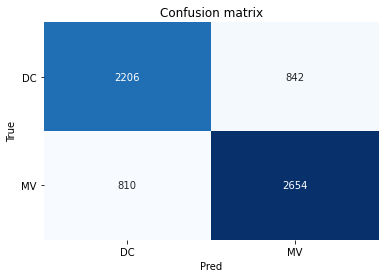

In [175]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

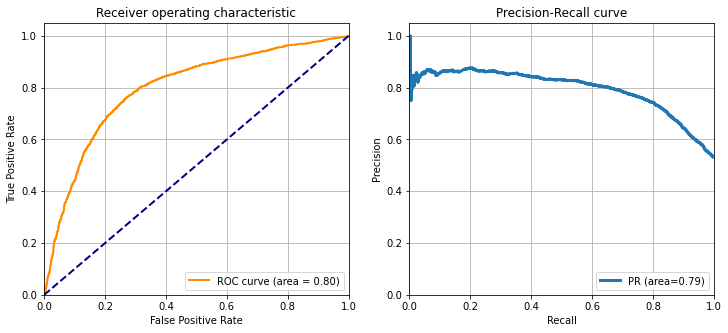

In [176]:
# plot ROC and PR curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label="MV")
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
ax[0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax[0].set(
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1], pos_label="MV")
ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format("PR", auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="lower right")
ax[1].grid(True)

### TF-IDF

In [177]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.04605374, 0.03625293, 0.        , 0.        ,
       0.        , 0.        , 0.03971133, 0.        , 0.        ,
       0.03660491, 0.        , 0.02650208, 0.        , 0.        ,
       0.        , 0.        , 0.07837603, 0.        , 0.        ,
       0.04493148, 0.        , 0.11363421, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0373468 , 0.        ,
       0.        , 0.        , 0.03265362, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02577982, 0.        , 0.        , 0.        , 0.        ,
       0.04956526, 0.        , 0.        , 0.        , 0.        ,
       0.03888315, 0.        , 0.        , 0.03463823, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04461347, 0.        , 0.        , 0.        , 0.     

In [178]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          DC       0.78      0.78      0.78      3048
          MV       0.81      0.80      0.81      3464

    accuracy                           0.79      6512
   macro avg       0.79      0.79      0.79      6512
weighted avg       0.79      0.79      0.79      6512



(array([0.5, 1.5]), [Text(0, 0.5, 'DC'), Text(0, 1.5, 'MV')])

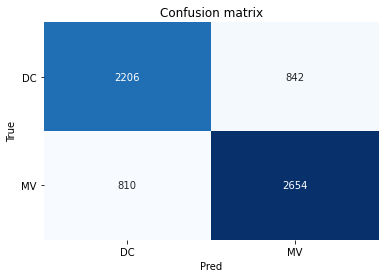

In [179]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

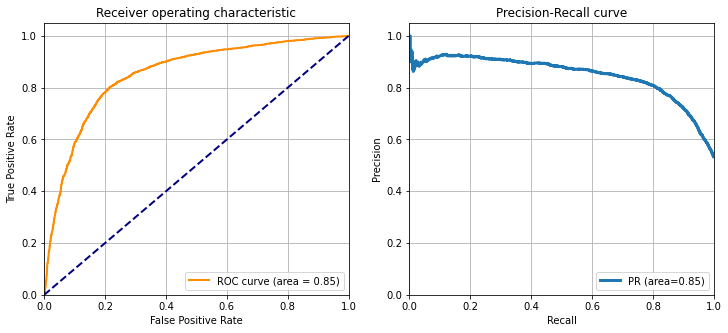

In [180]:
# plot ROC and PR curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label="MV")
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
ax[0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax[0].set(
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1], pos_label="MV")
ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format("PR", auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="lower right")
ax[1].grid(True)

### TF-IDF的效果比較好

### 4. 比較模型準度

#### CV 使用TF-IDF 做轉換

In [181]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])      
        
    
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label="MV")
        roc_auc = auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
        ax[0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax[0].set(
            xlim=[0.0, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="Receiver operating characteristic",
        )
        ax[0].legend(loc="lower right")
        ax[0].grid(True)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1], pos_label="MV")
        ax[1].plot(
                recall,
                precision,
                lw=3,
                label="{0} (area={1:0.2f})".format("PR-", auc(recall, precision)),
            )
        ax[1].set(
            xlim=[0.0, 1.0],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1].legend(loc="lower right")
        ax[1].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

now training: clf_logistic
              precision    recall  f1-score   support

          DC       0.77      0.79      0.78      7180
          MV       0.80      0.79      0.80      8012

    accuracy                           0.79     15192
   macro avg       0.79      0.79      0.79     15192
weighted avg       0.79      0.79      0.79     15192



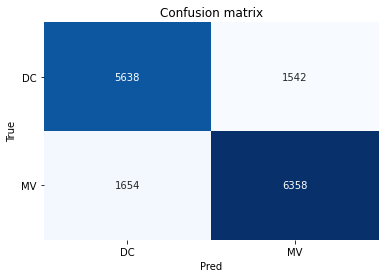

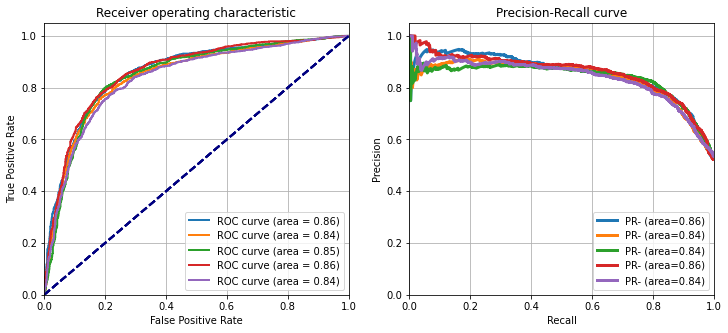

now training: clf_dtree
              precision    recall  f1-score   support

          DC       0.70      0.78      0.74      7180
          MV       0.78      0.70      0.74      8012

    accuracy                           0.74     15192
   macro avg       0.74      0.74      0.74     15192
weighted avg       0.74      0.74      0.74     15192



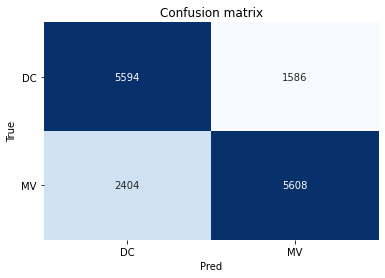

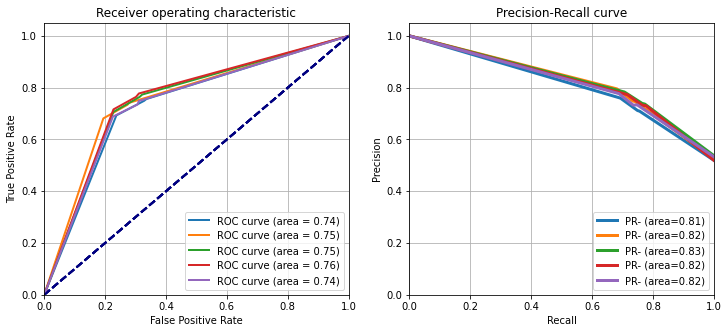

now training: clf_rf
              precision    recall  f1-score   support

          DC       0.77      0.78      0.77      7180
          MV       0.80      0.79      0.80      8012

    accuracy                           0.78     15192
   macro avg       0.78      0.78      0.78     15192
weighted avg       0.78      0.78      0.78     15192



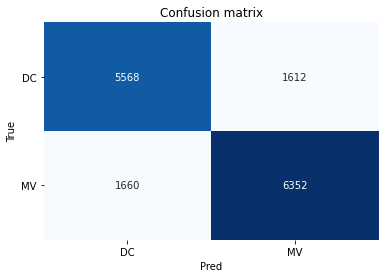

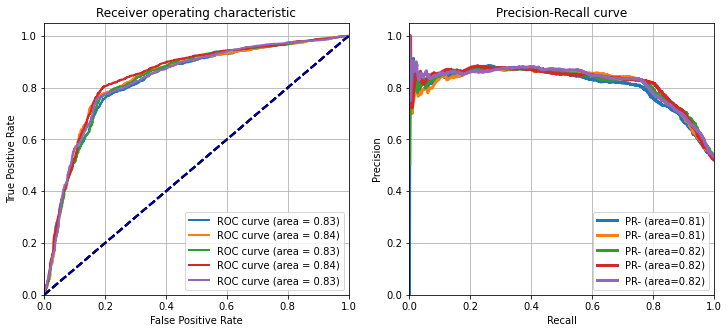

In [182]:
# 準備訓練資料
X = data["words"]
y = data["category"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression(max_iter=1000)
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [183]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'DC': {'f1-score': 0.7791597567716971,
        'precision': 0.7731760833790455,
        'recall': 0.7852367688022284,
        'support': 7180},
 'MV': {'f1-score': 0.7991452991452991,
        'precision': 0.8048101265822785,
        'recall': 0.7935596605092361,
        'support': 8012},
 'accuracy': 0.7896261190100052,
 'macro avg': {'f1-score': 0.7891525279584981,
               'precision': 0.788993104980662,
               'recall': 0.7893982146557322,
               'support': 15192},
 'weighted avg': {'f1-score': 0.7896997887291286,
                  'precision': 0.7898593347050266,
                  'recall': 0.7896261190100052,
                  'support': 15192}}


In [184]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          DC       0.78      0.78      0.78      3048
          MV       0.81      0.80      0.81      3464

    accuracy                           0.79      6512
   macro avg       0.79      0.79      0.79      6512
weighted avg       0.79      0.79      0.79      6512



### 最佳模型 - Logistic Regression

In [185]:

model_set[best_model_name]

LogisticRegression(max_iter=1000)

In [186]:
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
fprop

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


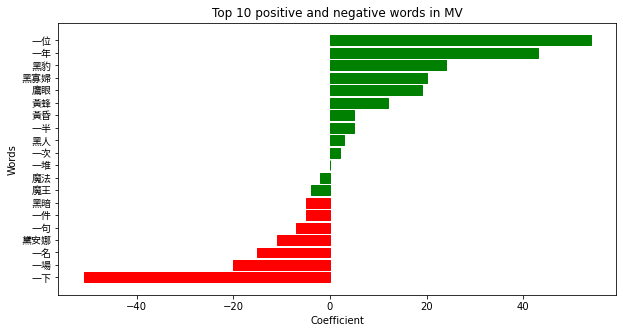

In [187]:
# plot logistic regression coef to see top 10 positive coef words are important in classification
# plot logistic regression coef to see top 10 negative coef words are important in classification
# plot in one plot
fig, ax = plt.subplots(figsize=(10, 5))
coef = model_set[best_model_name].coef_[0]
coef = coef / np.linalg.norm(coef)
coef = coef * 100
coef = coef[:10]
coef = np.append(coef, model_set[best_model_name].coef_[0][-10:])
coef = coef / np.linalg.norm(coef)
coef = coef * 100
coef = coef.astype(int)
words = vectorizer.get_feature_names()[:10]
words.extend(vectorizer.get_feature_names()[-10:])
words = [w for _, w in sorted(zip(coef, words))]
coef = sorted(coef)
ax.barh(words, coef, color="darkorange")
ax.set(
    xlabel="Coefficient",
    ylabel="Words",
    title="Top 10 positive and negative words in MV",
)

#set positive bar color
for i in range(7):
    ax.get_children()[i].set_color("red")

#set negative bar color
for i in range(7, 20):
    ax.get_children()[i].set_color("green")
    

#set yaxisfontproperties
ax.set_yticklabels(words, fontproperties=fprop)

plt.show()

### 5. 主題模型

In [188]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim

In [189]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [190]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans CJK JP"]
# plt.plot((1, 2, 3), (4, 3, -1))
# plt.title("聲量圖")

In [191]:
df = pd.read_csv("./raw_data/clean_data.csv")
df.head()

,content,artUrl,artCatagory,words,category
0,影評輕輕鬆鬆無責任瞬間移動移動世界原文與劇照請參照請任意轉載但請記得告知原作者謝謝我喜愛好萊...,https://www.ptt.cc/bbs/movie/M.1203700706.A.0B...,movie,影評 輕輕鬆鬆 責任 瞬間 移動 移動 世界 原文 劇照 參照 任意 轉載 記得 告知 作者...,MV
1,好雷鋼鐵人首次製作的作品可說繳出一張優秀的成績單先講不滿的地方就是前半的精彩反而令理論上的後...,https://www.ptt.cc/bbs/movie/M.1209570769.A.74...,movie,好雷 鋼鐵人 首次 製作 作品 可說 繳出 一張 優秀 成績單 先講 地方 前半 精彩 理論...,MV
2,請益鋼鐵人和移動世界有關係嗎片尾我也來補充一下好了以下是寫給對美漫完全沒有概念的人看的而且主...,https://www.ptt.cc/bbs/movie/M.1209836216.A.8D...,movie,請益 鋼鐵人 移動 世界 關係 片尾 補充 一下 好了 以下 寫給 美漫 完全 概念 主題 ...,MV
3,好雷鋼鐵人時光之硯鋼鐵人時光之硯部落格個人板陽光耀眼劇照版在此鋼鐵人切入了沒人佔領的幽默這一...,https://www.ptt.cc/bbs/movie/M.1210080500.A.5D...,movie,好雷 鋼鐵人 時光 之硯 鋼鐵人 時光 之硯 部落格 人板 陽光 耀眼 劇照 鋼鐵人 切入 ...,MV
4,鋼鐵人小勞勃道尼的浮沉人生圖文版小勞勃道尼的浮沉人生鋼鐵人與小勞勃道尼我在人生的不同階段不時...,https://www.ptt.cc/bbs/movie/M.1210388646.A.DC...,movie,鋼鐵人 小勞勃道尼 浮沉 人生 圖文 小勞勃道尼 浮沉 人生 鋼鐵人 小勞勃道尼 人生 階段...,MV


### LDA 主題模型

In [192]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")
df["content"] = df["content"].astype(str)
# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

df["words"] = df["content"].apply(getToken)
df.head()

Building prefix dict from /home/nychian/HW_3/dict/dict.txt ...
2023-05-07 17:52:30,063 : DEBUG : Building prefix dict from /home/nychian/HW_3/dict/dict.txt ...
Loading model from cache /tmp/jieba.u20247a3849bc6c9fcbba07ee911f2fa2.cache
2023-05-07 17:52:30,065 : DEBUG : Loading model from cache /tmp/jieba.u20247a3849bc6c9fcbba07ee911f2fa2.cache
Loading model cost 0.629 seconds.
2023-05-07 17:52:30,694 : DEBUG : Loading model cost 0.629 seconds.
Prefix dict has been built successfully.
2023-05-07 17:52:30,696 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,words,category
0,影評輕輕鬆鬆無責任瞬間移動移動世界原文與劇照請參照請任意轉載但請記得告知原作者謝謝我喜愛好萊...,https://www.ptt.cc/bbs/movie/M.1203700706.A.0B...,movie,"[影評, 輕輕鬆鬆, 責任, 瞬間, 移動, 移動, 世界, 原文, 劇照, 參照, 任意,...",MV
1,好雷鋼鐵人首次製作的作品可說繳出一張優秀的成績單先講不滿的地方就是前半的精彩反而令理論上的後...,https://www.ptt.cc/bbs/movie/M.1209570769.A.74...,movie,"[好雷, 鋼鐵人, 首次, 製作, 作品, 可說, 繳出, 一張, 優秀, 成績單, 先講,...",MV
2,請益鋼鐵人和移動世界有關係嗎片尾我也來補充一下好了以下是寫給對美漫完全沒有概念的人看的而且主...,https://www.ptt.cc/bbs/movie/M.1209836216.A.8D...,movie,"[請益, 鋼鐵人, 移動, 世界, 關係, 片尾, 補充, 一下, 好了, 以下, 寫給, ...",MV
3,好雷鋼鐵人時光之硯鋼鐵人時光之硯部落格個人板陽光耀眼劇照版在此鋼鐵人切入了沒人佔領的幽默這一...,https://www.ptt.cc/bbs/movie/M.1210080500.A.5D...,movie,"[好雷, 鋼鐵人, 時光, 之硯, 鋼鐵人, 時光, 之硯, 部落格, 人板, 陽光, 耀眼...",MV
4,鋼鐵人小勞勃道尼的浮沉人生圖文版小勞勃道尼的浮沉人生鋼鐵人與小勞勃道尼我在人生的不同階段不時...,https://www.ptt.cc/bbs/movie/M.1210388646.A.DC...,movie,"[鋼鐵人, 小勞勃道尼, 浮沉, 人生, 圖文, 小勞勃道尼, 浮沉, 人生, 鋼鐵人, 小...",MV


In [193]:
#save df
#df.to_csv("./raw_data/clean_data_topic.csv", index=False)

In [194]:
docs = df['words'].to_list()
docs[0]

['影評',
 '輕輕鬆鬆',
 '責任',
 '瞬間',
 '移動',
 '移動',
 '世界',
 '原文',
 '劇照',
 '參照',
 '任意',
 '轉載',
 '記得',
 '告知',
 '作者',
 '謝謝',
 '喜愛',
 '好萊塢',
 '電影',
 '世界',
 '上更多',
 '好萊塢',
 '電影',
 '之後',
 '確信',
 '這件',
 '事並',
 '發現',
 '好萊塢',
 '電影',
 '有著',
 '更深',
 '內涵',
 '好萊塢',
 '服務',
 '觀眾',
 '用心',
 '獨一無二',
 '提供',
 '匪夷所思',
 '爆炸',
 '震破',
 '耳膜',
 '巨響',
 '觀眾',
 '忘卻',
 '煩惱',
 '雲霄飛車',
 '戲院',
 '活力',
 '面對',
 '人生',
 '看完',
 '大衛林區',
 '肯羅區',
 '電影',
 '同樣',
 '舒暢',
 '效果',
 '小心',
 '朋友',
 '移動',
 '世界',
 '一如',
 '標準',
 '好萊塢',
 '電影',
 '流暢',
 '特效',
 '砰砰',
 '聲音',
 '帥到',
 '流湯',
 '美到',
 '流膏',
 '男女',
 '主角',
 '更棒',
 '它給',
 '劇情',
 '自由',
 '貼心',
 '地連',
 '劇情',
 '省略',
 '好萊塢',
 '電影',
 '全世界',
 '海報',
 '幾款',
 '日本',
 '特別版',
 '日本版',
 '海報',
 '上面',
 '副標',
 '總是',
 '更帥',
 '更酷',
 '美版',
 '台版',
 '移動',
 '改變',
 '世界',
 '日版',
 '行先',
 '制限',
 '前往',
 '去向',
 '無制限',
 '喜歡',
 '哪一個',
 '其名',
 '快速',
 '地間',
 '無痕',
 '移動',
 '東京',
 '把妹',
 '埃及',
 '曬太陽',
 '墾丁',
 '吃交',
 '瞬間',
 '移動',
 '超能力',
 '老式',
 '能力',
 '藍魔鬼',
 '戰警',
 '續集',
 '白宮',
 '惡靈',
 '戰警',
 '黑心',
 '陣子',
 '電影版',
 '擔任',
 '壞蛋',


In [195]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-05-07 18:01:02,015 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-05-07 18:01:04,783 : INFO : adding document #10000 to Dictionary<104901 unique tokens: ['一下', '一天個', '一如', '一直', '一碟']...>
2023-05-07 18:01:07,849 : INFO : adding document #20000 to Dictionary<147065 unique tokens: ['一下', '一天個', '一如', '一直', '一碟']...>
2023-05-07 18:01:08,432 : INFO : built Dictionary<147463 unique tokens: ['一下', '一天個', '一如', '一直', '一碟']...> from 21841 documents (total 4803123 corpus positions)
2023-05-07 18:01:08,433 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<147463 unique tokens: ['一下', '一天個', '一如', '一直', '一碟']...> from 21841 documents (total 4803123 corpus positions)", 'datetime': '2023-05-07T18:01:08.433680', 'gensim': '4.2.0', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-5.4.0-147-generic-x86_64-with-debian-bullseye-sid', 'event': 'created'}
2023-05-07 18:01:08,643 : INFO : discarding 102466 tokens: 

Dictionary<44997 unique tokens: ['一下', '一如', '一直', '一碟', '一笑']...>


In [196]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一下: 0
一如: 1
一直: 2
一碟: 3
一笑: 4
一絲: 5
一課: 6
一進: 7
七情六慾: 8
三大: 9
上廁所: 10
上班族: 11


In [197]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

### Topic 數量選擇

In [198]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-05-07 18:01:13,112 : INFO : using symmetric alpha at 0.5
2023-05-07 18:01:13,114 : INFO : using symmetric eta at 0.5
2023-05-07 18:01:13,124 : INFO : using serial LDA version on this node
2023-05-07 18:01:13,133 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 21841 documents, updating every 94000 documents, evaluating every ~21841 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-07 18:01:13,134 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-07 18:01:13,136 : INFO : training LDA model using 47 processes
2023-05-07 18:01:19,116 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/21841, outstanding queue size 1
2023-05-07 18:01:19,233 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/21841, outstanding queue size 2
2023-05-07 18:01:19,241 : INFO : PROGRESS: pass 0, dispatched chunk #2 = docu

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5945.610494,0.014298
1,3,5884.929803,0.015797
2,4,5831.409967,0.016477
3,5,5837.397895,0.018306
4,6,5834.328055,0.017305
5,7,5791.682639,0.014760
6,8,5824.760724,0.012261
7,9,5825.992873,0.011117


<AxesSubplot:xlabel='topic_num'>

2023-05-07 16:45:50,297 : WARNING : findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


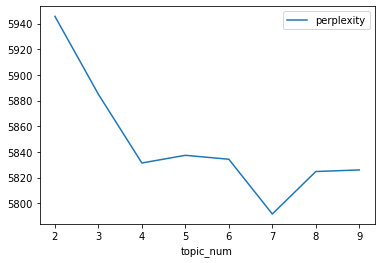

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

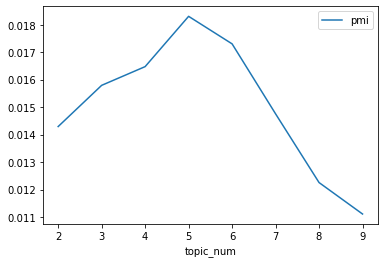

In [ ]:
result.plot.line(x='topic_num', y='pmi')

#### Perplexity 7 最好, coherence 最高則是 5

### 視覺化呈現

以下用主題數 7 來做 LDAvis 的結果範例

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2023-05-07 16:47:34,168 : INFO : using symmetric alpha at 0.14285714285714285
2023-05-07 16:47:34,170 : INFO : using symmetric eta at 0.14285714285714285
2023-05-07 16:47:34,180 : INFO : using serial LDA version on this node
2023-05-07 16:47:34,222 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 21841 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-07 16:47:34,227 : INFO : PROGRESS: pass 0, at document #2000/21841
2023-05-07 16:47:36,184 : INFO : merging changes from 2000 documents into a model of 21841 documents
2023-05-07 16:47:36,199 : INFO : topic #1 (0.143): 0.023*"電影" + 0.010*"英雄" + 0.009*"漫威" + 0.008*"隊長" + 0.007*"美國" + 0.006*"角色" + 0.006*"知道" + 0.005*"復仇" + 0.005*"系列" + 0.004*"鋼鐵人"
2023-05-07 16:47:36,201 : INFO : topic #6 (0.143): 0.014*"電影" + 0.011*"英雄" + 0.007*"漫威" + 0.005*"導演" + 0.005*"漫畫" + 0.005*"角色" + 0.004*"美國

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
p

2023-05-07 16:50:32,136 : INFO : Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-05-07 16:50:32,136 : INFO : NumExpr defaulting to 8 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.117294  0.039333       1        1  24.519457
4      0.171385  0.168467       2        1  16.635692
2     -0.112609 -0.062029       3        1  14.134183
3      0.031269 -0.108835       4        1  12.768485
1      0.025194  0.173738       5        1  11.377404
5     -0.187763 -0.020582       6        1  10.949975
6      0.189818 -0.190092       7        1   9.614804, topic_info=     Term          Freq         Total Category  logprob  loglift
5540   漫威  24977.000000  24977.000000  Default  30.0000  30.0000
694    超人  35591.000000  35591.000000  Default  29.0000  29.0000
339    電影  87185.000000  87185.000000  Default  28.0000  28.0000
682   蝙蝠俠  20800.000000  20800.000000  Default  27.0000  27.0000
666    票房  12519.000000  12519.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
162    故事   1461.617732  15189.642258   Topic7  -5.7121   0.0008
586    動畫    987.734419   4190.787234   Topic7  -6.1039   0.8966
669    系列   1103.992349  11101.136555   Topic7  -5.9927   0.0338
19     世界   1117.832466  12195.535742   Topic7  -5.9802  -0.0478
294    角色   1014.118007  24561.211259   Topic7  -6.0776  -0.8453

[648 rows x 6 columns], token_table=       Topic      Freq Term
term                       
0          1  0.517384   一下
0          2  0.005576   一下
0          3  0.021608   一下
0          4  0.014464   一下
0          5  0.147948   一下
...      ...       ...  ...
34554      3  0.991426   齊爾
26451      3  0.988388   齊莫
4801       2  0.009965   龐德
4801       3  0.053560   龐德
4801       7  0.935435   龐德

[1815 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2, 6, 7])

### 可以看到 4 和 7 和 DC 漫威的相關沒那麼多, 感覺比較像是在討論電影相關的議題。
### 1 和 2 主要是 DC 電影的主題
### 3、5、6 主要是 漫威電影的主題

### 5 和 2 的討論角度 比較像是在討論兩個公司, 可以看到迪士尼、華納等詞眼, 以及未來、階段, 比較像是在說各公司未來的方向

### 1 6 3 比較著重在電影方面, 可以看到裡面出現比較多角色的名稱。

## 6. GuidedLDA

In [ ]:
import guidedlda

In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一下', '一如', '一直', '一碟', '一笑', '一絲', '一課', '一進', '七情六慾', '三大')

In [ ]:
word2id = dictionary.token2id

In [ ]:
word2id

In [ ]:
seed_topic_list = [
    ["漫威", "迪士尼","蜘蛛俠","鋼鐵人"],
    ["華納","超人","蝙蝠俠"],
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=7, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-05-07 17:05:05,031 : INFO : n_documents: 21841
2023-05-07 17:05:05,032 : INFO : vocab_size: 44997
2023-05-07 17:05:05,033 : INFO : n_words: 4598414
2023-05-07 17:05:05,033 : INFO : n_topics: 7
2023-05-07 17:05:05,034 : INFO : n_iter: 100
2023-05-07 17:05:06,264 : WARNING : all zero row in document-term matrix found
2023-05-07 17:06:15,808 : INFO : <0> log likelihood: -50608431
2023-05-07 17:06:20,470 : INFO : <20> log likelihood: -42663141
2023-05-07 17:06:24,841 : INFO : <40> log likelihood: -41962757
2023-05-07 17:06:29,180 : INFO : <60> log likelihood: -41736804
2023-05-07 17:06:33,503 : INFO : <80> log likelihood: -41630222
2023-05-07 17:06:37,803 : INFO : <99> log likelihood: -41563928


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 電影 漫威 新聞 票房 上映 導演 英雄 角色 聯盟 蜘蛛人
Topic 1: 超人 蝙蝠俠 電影 英雄 正義 聯盟 神力女 角色 小丑 自殺
Topic 2: 隊長 復仇 漫威 英雄 美國 蜘蛛人 鋼鐵人 宇宙 聯盟 電影
Topic 3: 世界 人類 美國 社會 女性 成為 主角 本片 面對 母親
Topic 4: 電影 台灣 英語 最佳 美國 票房 導演 日本 奧斯卡 上映
Topic 5: 電影 故事 角色 觀眾 作品 英雄 導演 漫畫 世界 飾演
Topic 6: 電影 劇情 最後 知道 看到 喜歡 這部 主角 感覺 角色


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.094310 -0.112211       1        1  20.513526
6     -0.118970 -0.064049       2        1  19.392132
5      0.008854 -0.000700       3        1  14.247446
1     -0.131865 -0.100676       4        1  14.149946
2     -0.145191 -0.041199       5        1  11.995782
3     -0.038368  0.329808       6        1  11.437656
4      0.331230 -0.010973       7        1   8.263512, topic_info=     Term          Freq         Total Category  logprob  loglift
694    超人  29470.000000  29470.000000  Default  30.0000  30.0000
682   蝙蝠俠  17008.000000  17008.000000  Default  29.0000  29.0000
714    隊長  16349.000000  16349.000000  Default  28.0000  28.0000
5540   漫威  31272.000000  31272.000000  Default  27.0000  27.0000
618    復仇  15803.000000  15803.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
35     作品   1263.794493  10557.082499   Topic7  -5.7060   0.3706
19     世界   1241.815633  11778.000468   Topic7  -5.7236   0.2437
20     主角   1157.896345  11148.906097   Topic7  -5.7935   0.2286
2340   星際   1015.033749   5753.756556   Topic7  -5.9252   0.7584
210    演員   1079.971293  10305.156375   Topic7  -5.8632   0.2376

[649 rows x 6 columns], token_table=       Topic      Freq Term
term                       
44456      7  1.000383  nan
0          1  0.017885   一下
0          2  0.575535   一下
0          4  0.197628   一下
0          5  0.179922   一下
...      ...       ...  ...
8659       5  0.999310  齊禮安
4801       1  0.094609   龐德
4801       2  0.121217   龐德
4801       6  0.007391   龐德
4801       7  0.777565   龐德

[1562 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 2, 3, 4, 5])

### 可以看到 GuidedLDA 在前三個topic 是有抓出 DC 和 漫威這兩個公司的主題的
### 但可能資料的問題, 裡面夾雜了其它討論電影的文章, 可以看到幾個topic 是和我們想要討論的主題無關。

In [ ]:
model = guidedlda.GuidedLDA(n_topics=3, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-05-07 17:10:46,560 : INFO : n_documents: 21841
2023-05-07 17:10:46,561 : INFO : vocab_size: 44997
2023-05-07 17:10:46,562 : INFO : n_words: 4598414
2023-05-07 17:10:46,563 : INFO : n_topics: 3
2023-05-07 17:10:46,564 : INFO : n_iter: 100
2023-05-07 17:10:47,752 : WARNING : all zero row in document-term matrix found
2023-05-07 17:11:57,256 : INFO : <0> log likelihood: -45881230
2023-05-07 17:12:00,098 : INFO : <20> log likelihood: -41544381
2023-05-07 17:12:02,859 : INFO : <40> log likelihood: -41322457
2023-05-07 17:12:05,522 : INFO : <60> log likelihood: -41228242
2023-05-07 17:12:08,182 : INFO : <80> log likelihood: -41185414
2023-05-07 17:12:10,812 : INFO : <99> log likelihood: -41159853


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 電影 漫威 新聞 票房 上映 英雄 導演 角色 聯盟 復仇
Topic 1: 電影 超人 英雄 角色 蝙蝠俠 劇情 漫威 隊長 知道 最後
Topic 2: 電影 世界 故事 主角 美國 導演 最後 作品 觀眾 成為


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.027860 -0.166038       1        1  39.126785
2     -0.191729  0.063507       2        1  31.622597
0      0.163869  0.102532       3        1  29.250618, topic_info=     Term          Freq         Total Category  logprob  loglift
5540   漫威  31284.000000  31284.000000  Default  30.0000  30.0000
1926   新聞  12651.000000  12651.000000  Default  29.0000  29.0000
666    票房  12939.000000  12939.000000  Default  28.0000  28.0000
694    超人  29484.000000  29484.000000  Default  27.0000  27.0000
561    上映  13099.000000  13099.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
262    美國   7129.537435  17497.766250   Topic3  -5.2400   0.3314
714    隊長   5827.988820  16357.022017   Topic3  -5.4415   0.1973
652    漫畫   5094.243287  11769.369734   Topic3  -5.5761   0.3919
35     作品   4710.376414  10560.823248   Topic3  -5.6544   0.4219
694    超人   5846.982233  29484.296964   Topic3  -5.4383  -0.3887

[308 rows x 6 columns], token_table=       Topic      Freq Term
term                       
0          1  0.846348   一下
0          2  0.102799   一下
0          3  0.050953   一下
1430       1  0.818327   一點
1430       2  0.152502   一點
...      ...       ...  ...
8470       2  1.000177   體制
18106      3  1.000268   麥特
12895      1  0.932454  黛安娜
12895      2  0.056189  黛安娜
12895      3  0.011141  黛安娜

[501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### 可以看到主題 1 是漫威相關, 主題 2是DC 相關的討論, 主題3 則是其它